<a href="https://colab.research.google.com/github/BioML-UGent/Advanced-AI-for-Bioinformatics/blob/main/05_VAEs/PClab_5_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***VAE for image generation***
Consider VAE model from
*Auto-Encoding Variational Bayes (2014, D.P. Kingma et. al.)*.  
We will implement a VAE model using Torch and apply it to the MNIST dataset.


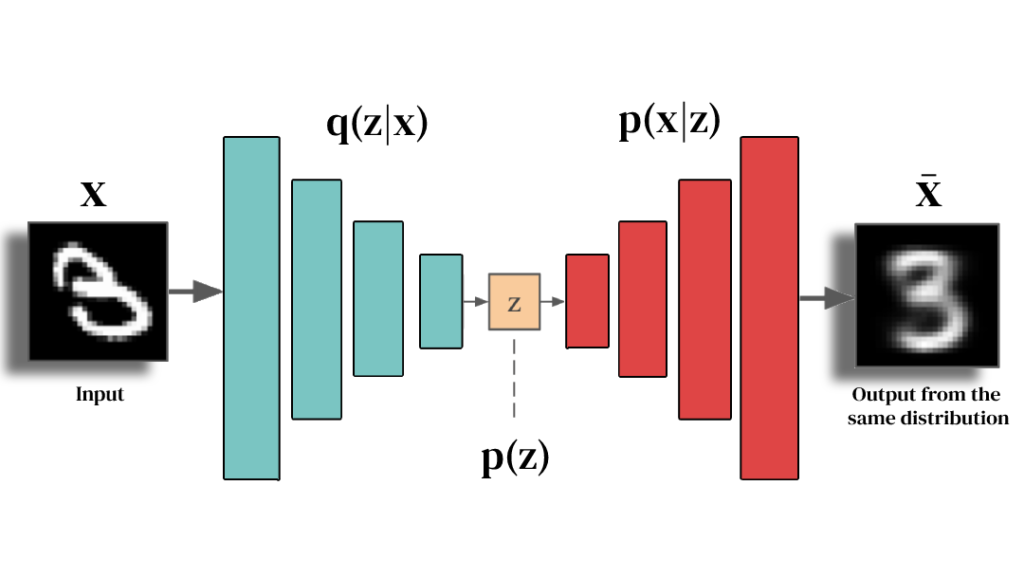


**Generative model:** We model each pixel value $\in \{0,1\}$ as a sample drawn from a Bernoulli distribution. Through a decoder, the latent random variable $z_n$  associated with an image $n$ is mapped to the success parameters of the Bernoulli distributions associated with the pixels of that image. Our generative model is described as follows:

$ z_n \sim N(0,I) $

$ \theta_n = g(z_n) $

$ x_n \sim Bern(\theta_n) $

where $g$ is the decoder. We choose the prior on $z_n$ to be the standard multivariate normal distribution, for computational convenience.  

**Inference model:** We infer the posterior distribution of $z_n$ via variational inference. The variational distribution $ q(z_n|x_n) $ is chosen to be multivariate Gaussian with a diagonal covariance matrix. The mean and covariance of this distribution are obtained by applying an encoder to $x_n$.

$ q(z_n|x_n) \sim q( \mu_n, \sigma^2_n) $

where $ \mu_n, \sigma^2_n = f(x_n)  $ and $f$ is the encoder.






**Implementation:**
Let's start with importing Torch and other necessary libraries:

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

### ***Step1: Model Hyperparameters***



In [2]:
dataset_path = '~/datasets'

batch_size = 100

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 400
latent_dim = 200

# Learning rate
lr = 1e-3

# Number of epoch
epochs = 10 # can try something greater if you are not satisfied with the results

### ***Step2: Load Dataset***



In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_labels = test_dataset.targets

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 129MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 37.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 105MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.79MB/s]


### ***Step3: Define the model***


### **Exercise 1**
Define your encoder and decoder accoding to the architecture described below.
***


*Encoder: Four linear layers (two common, one for mean, one for log variance).*

*Decoder: Three linear layers.*

Make use of LeakyReLU activation function for each layer, except the last layer of decoder, which uses Sigmoid to make sure the parameter $\theta \in [0,1]$.

In [4]:
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_enc1 = nn.Linear(input_dim, hidden_dim) # FC stands for a fully connected layer
        self.FC_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var  = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # will use this to add non-linearity to our model

        self.training = True

    def forward(self, x):
        h_1     = self.LeakyReLU(self.FC_enc1(x))
        h_2     = self.LeakyReLU(self.FC_enc2(h_1))
        mean    = self.FC_mean(h_2)  # mean
        log_var = self.FC_var(h_2)   # log of variance

        return mean, log_var

In [5]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_dec1   = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec2   = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # again for non-linearity

    def forward(self, z):
        h_out_1  = self.LeakyReLU(self.FC_dec1(z))
        h_out_2  = self.LeakyReLU(self.FC_dec2(h_out_1))

        theta = torch.sigmoid(self.FC_output(h_out_2))
        return theta


### **Exercise 2**

 Below implement the reparameterization function.

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        #  L = 1;
        # epsilon = torch.randn_like(var)       # sampling epsilon
        # z = mean + torch.sqrt(var)*epsilon    # reparameterization trick

        #  L > 1;
        L = 5
        bs = var.size(0)
        latent_dims = var.size(1)
        eps = torch.randn((L, bs, latent_dims))
        mu = mean.unsqueeze(0).expand((L, bs, latent_dims))
        std = torch.sqrt(var).unsqueeze(0).expand((L, bs, latent_dims))
        z = mu + (eps * std)

        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(log_var)) # takes exponential function (log var -> var)

        theta = self.Decoder(z)

        return theta, mean, log_var, z

### ***Step4: Model initialization***


In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder)

### ***Step5: Loss function and optimizer***


Our objective function is ELBO:
$E_{q(z|x)}\big[\log \frac{p(x,z)}{q(z|x)}\big]$

 ELBO can be rewritten as :

  $E_{q(z|x)}\big(\log p(x|z)\big) - D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$


Consider the first term: $E_{q(z|x)}\big(\log p(x|z)\big)$

$E_{q(z|x)}\big(\log p(x|z)\big) = \int q(z|x) \log p(x|z) dz $

We can approximate this integral by Monte Carlo integration as following:

$\approx \frac{1}{L} \sum_{l=1}^L \log p(x|z_l) $, where $z_l \sim q(z|x)$.

Now we can compute this term using the analytic expression for $p(x|z)$. ( Remember we model each pixel as a sample drawn from a Bernoulli distribution).

Consider the second term: $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$

Kullback–Leibler divergence can be computed using the closed-form analytic expression when both the variational and the prior distributions are Gaussian. Read more about that [here](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/).

### **Exercise 3**

Now use the above findings to implement the loss function, which is the negative of ELBO:

In [9]:
from torch.optim import Adam
from torch.distributions import Bernoulli


def loss_function(x, theta, mean, log_var):

    reconstruction_loss = -torch.log( (x * theta + (1-x) * (1-theta)) ).mean(axis=0).sum()

    KLD      = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + KLD #can be also done as 600*(batch_loss) = N/M*(batch_loss)

# optimizer
optimizer = Adam(model.parameters(), lr=lr)

### ***Step6: Train the model***


In [10]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()

        theta, mean, log_var, z = model(x)
        loss = loss_function(x, theta, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  163.38338772628862
	Epoch 2 complete! 	Average Loss:  108.6746119998174
	Epoch 3 complete! 	Average Loss:  97.86148339680717
	Epoch 4 complete! 	Average Loss:  92.88790725427796
	Epoch 5 complete! 	Average Loss:  89.81455417231845
	Epoch 6 complete! 	Average Loss:  87.14593371765443
	Epoch 7 complete! 	Average Loss:  85.33745166912301
	Epoch 8 complete! 	Average Loss:  84.11526921496765
	Epoch 9 complete! 	Average Loss:  83.14060600675606
	Epoch 10 complete! 	Average Loss:  82.39584244411259
Finish!!


### ***Step7: Generate images from test dataset***
With our model trained, now we can start generating images.

First, we will generate images from the latent representations of test data.

Basically, we will sample $z$ from $q(z|x)$ and give it to the generative model (i.e., decoder) $p(x|z)$. The output of the decoder will be displayed as the generated image.


### **Exercise 4**

Write a code to get the reconstructions of test data, and then display them using the show_image function

In [11]:
model.eval()
# below we get decoder outputs for test data
with torch.no_grad():
    z_test = []
    x_test = []
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x_test.append(x)
        mean, log_var = encoder(x)
        z = model.reparameterization(mean, torch.exp(log_var))
        z_test.append(z)
        theta = decoder(z).mean(axis=0)

100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


In [12]:
np.array(z_test).shape

(100, 5, 100, 200)

A helper function to display images:

In [13]:
import matplotlib.pyplot as plt
def show_image(theta, idx):
    x_hat = theta.view(batch_size, 28, 28)
    #x_hat = Bernoulli(x_hat).sample() # sample pixel values (you can also try this, and observe how the generated images look)
    fig = plt.figure()
    plt.imshow(x_hat[idx].cpu().numpy(), cmap='gray')

First display an image from the test dataset,

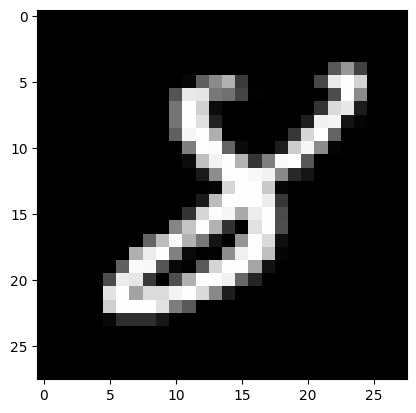

In [16]:
show_image(x, idx=26) # try different indices as well

Now display its reconstruction and compare:

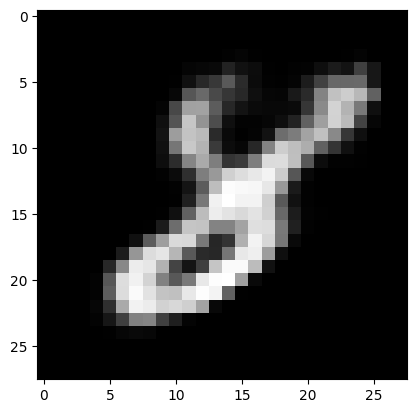

In [18]:
show_image(theta, idx=26)

### ***Step8: Generate images from noise***

In the previous step, we sampled latent vector $z$ from $q(z|x)$. However, we know that the KL term in our loss function enforced $q(z|x)$ to be close to $N(0, I)$. Therefore, we can sample $z$ directly from noise $N(0, I)$, and pass it to the decoder $p(x|z)$.



### **Exercise 5**
Create images from noise and display.

In [19]:
with torch.no_grad():
    # insert your code here to create images from noise (it is enough to create theta value for each pixel)
    noise = torch.randn(batch_size, latent_dim)
    generated_images = decoder(noise)

Display a couple of generated images:

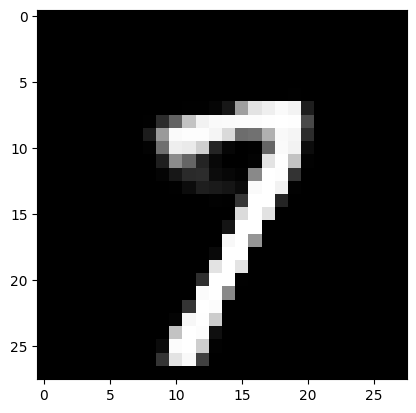

In [28]:
show_image(generated_images, idx=11)

### ***Step9: Latent representations***

Beside data generation, VAEs are also commonly used to obtain low-dimensional representations of data and these representations are then used for downstream tasks. In this section, you will visualize the latent representations learned by your model.

To this end, we will first project them to 2D using t-SNE:

In [23]:
from sklearn.manifold import TSNE
def get_2d_representations(z):
    tsne = TSNE()
    rep_2D = tsne.fit_transform(z)
    return rep_2D

In [24]:
z_test_array = np.array(z_test)[:,0,:,:].reshape(10000,200)
x_test_array = np.array(x_test).reshape(10000,784)
# Project the latent representations of first 200 test data into 2D
rep_2d = get_2d_representations(z_test_array[:200,:])

Now, visualize the latent space in 2D and comment on the plot:

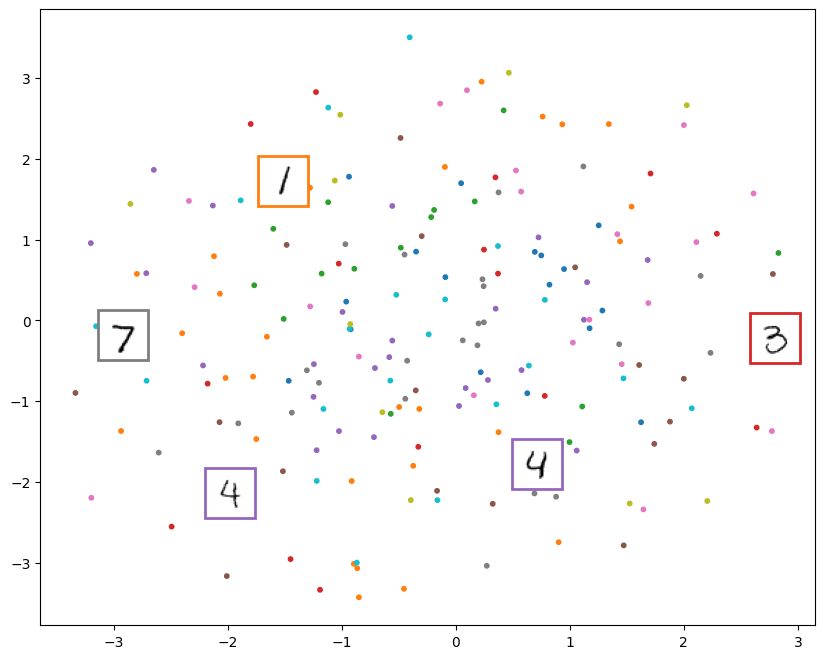

In [25]:
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
fig = plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(rep_2d[:, 0], rep_2d[:, 1], c=test_labels[:200], s=10, cmap=cmap)
image_positions = np.array([[1.0, 1.0]])
dist_coord1 = np.max(rep_2d[:, 0]) - np.min(rep_2d[:, 0])
dist_coord2 = np.max(rep_2d[:, 1]) - np.min(rep_2d[:, 1])
target_dist = np.sqrt(dist_coord1**2+dist_coord2**2)/2
for index, position in enumerate(rep_2d):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > target_dist:  # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = AnnotationBbox(
              OffsetImage(x_test_array[index].reshape(28, 28), cmap="binary"),
              position,
              bboxprops={"edgecolor": tuple(cmap([test_labels[:200][index]])[0]), "lw": 2},
          )
          plt.gca().add_artist(imagebox)

### **Exercise 6**
Comment on the learned latent representations.

.

.

.

### ***Step10: Disentangled Latent Space***
The KL term between the prior and the variational distributions often limits the latent representation capabilities of VAEs. One approach to overcome this problem is to use Maximum-Mean Discrepancy (MMD) instead of KL.

MMD is a framework to quantify the distance between two distributions by comparing all of their moments. It can be efficiently implemented using the kernel trick.  Letting $k(\cdot , \cdot)$ be any positive definite kernel, the
MMD between q and p is:
$D_{MMD}(q||p) = \mathbb{E}_{p(z),p(z')} \: \big[k(z,z')\big] - 2 \mathbb{E}_{q(z),p(z')}\: \big[k(z,z')\big] + \mathbb{E}_{q(z),q(z')}\: \big[k(z,z')\big]$

### **Exercise 7**  
Below you are given an implementation of the RBF kernel.
Implement MMD using this kernel:

In [29]:
def compute_rbf(x1: torch.Tensor, x2: torch.Tensor, latent_var: float = 2.0, eps: float = 1e-7) -> torch.Tensor:
    """
    Computes the RBF Kernel between x1 and x2.
    :param x1: (Tensor)
    :param x2: (Tensor)
    :param eps: (Float)
    :return:
    """
    z_dim = x2.size(-1)
    sigma = (2.0 / z_dim) * latent_var

    result = torch.exp(-((x1 - x2).pow(2).mean(-1) / sigma))
    return result

In [30]:
def MMD(prior_z: torch.Tensor, z: torch.Tensor):

    prior_z__kernel = compute_rbf(prior_z, prior_z)
    z__kernel = compute_rbf(z, z)
    priorz_z__kernel = compute_rbf(prior_z, z)

    mmd = prior_z__kernel.mean() + z__kernel.mean() - 2 * priorz_z__kernel.mean()
    return mmd

### **Exercise 8**
Now, define a new loss function which involves MMD instead of KL:

In [31]:
from torch.optim import Adam
def loss_mmd (x, theta, z, beta=1):
    reconstruction_loss = -torch.log( (x * theta + (1-x) * (1-theta)) ).mean(axis=0).sum()

    mmd = MMD(torch.randn_like(z), z)

    loss = reconstruction_loss + beta * mmd
    return loss

We can initialize another model and train it using the new loss:

In [32]:
encoder_2 = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_2 = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
# new model
model_2 = Model(Encoder=encoder_2, Decoder=decoder_2)
# its optimizer
optimizer_2 = Adam(model_2.parameters(), lr=lr)

In [33]:
print("Start training VAE...")
model_2.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer_2.zero_grad()

        theta_2, mean_2, log_var_2, z_2 = model_2(x)
        loss_2 = loss_mmd(x, theta_2, z_2, beta=1)

        overall_loss += loss_2.item()

        loss_2.backward()
        optimizer_2.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  121.02224174894356
	Epoch 2 complete! 	Average Loss:  58.410619277571996
	Epoch 3 complete! 	Average Loss:  44.92903864432257
	Epoch 4 complete! 	Average Loss:  38.74995684131756
	Epoch 5 complete! 	Average Loss:  34.61045486373774
	Epoch 6 complete! 	Average Loss:  31.634717567201847
	Epoch 7 complete! 	Average Loss:  29.207966871054623
	Epoch 8 complete! 	Average Loss:  27.273172825477356
	Epoch 9 complete! 	Average Loss:  25.69063148052744
	Epoch 10 complete! 	Average Loss:  24.350388931503677
Finish!!


### **Exercise 9**
Implement the function below to obtain the latent representations of the test set.

In [34]:
model_2.eval()
# below we get decoder outputs for test data
with torch.no_grad():
    z_test = []
    x_test = []
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x_test.append(x)
        # insert your code below to generate z, which will be displayed later
        mean, log_var = encoder_2(x)
        z = model_2.reparameterization(mean, torch.exp(log_var))
        z_test.append(z)

100%|██████████| 100/100 [00:01<00:00, 63.80it/s]


Now, project the learned latent representations into 2D and visualize them:

In [35]:
z_test_array = np.array(z_test)[:,1,:,:].reshape(10000,200)
x_test_array = np.array(x_test).reshape(10000,784)
rep_2d = get_2d_representations(z_test_array[:200,:])

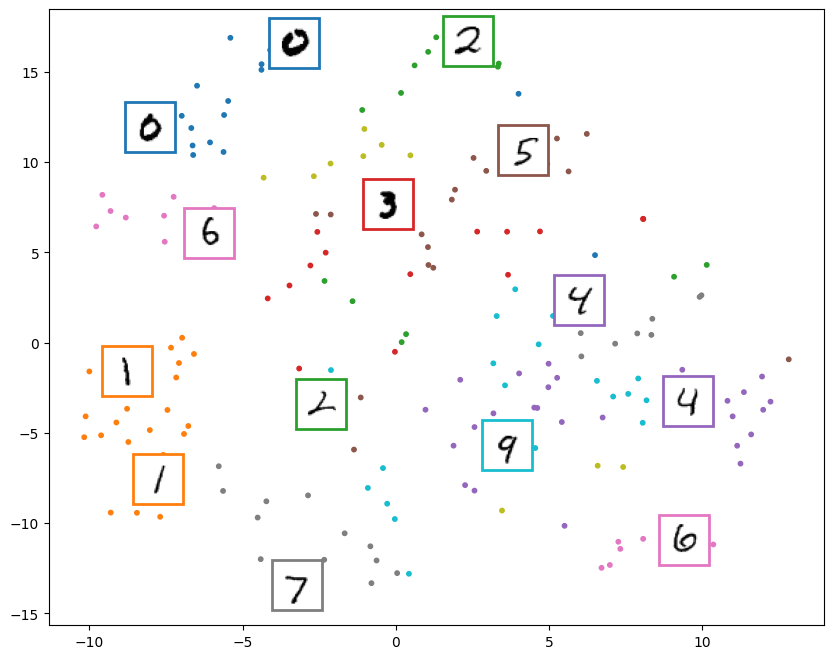

In [36]:
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
fig = plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(rep_2d[:, 0], rep_2d[:, 1], c=test_labels[:200], s=10, cmap=cmap)
image_positions = np.array([[1.0, 1.0]])
dist_coord1 = np.max(rep_2d[:, 0]) - np.min(rep_2d[:, 0])
dist_coord2 = np.max(rep_2d[:, 1]) - np.min(rep_2d[:, 1])
target_dist = np.sqrt(dist_coord1**2+dist_coord2**2)/1.5
for index, position in enumerate(rep_2d):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > target_dist:  # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = AnnotationBbox(
              OffsetImage(x_test_array[index].reshape(28, 28), cmap="binary"),
              position,
              bboxprops={"edgecolor": tuple(cmap([test_labels[:200][index]])[0]), "lw": 2},
          )
          plt.gca().add_artist(imagebox)

### **Exercise 10**
Analyze the plot and compare the latent representations obtained when using a loss function with Maximum Mean Discrepancy (MMD) against those obtained with a loss function involving the Kullback-Leibler (KL) divergence. Highlight the key differences between the two approaches and discuss scenarios where latent representations learned with MMD would be more advantageous. Provide concrete examples to these cases.

.

.

.
